In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import re
import nltk

from nltk.tokenize import TweetTokenizer

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.metrics import AUC

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import l2

import time

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

INTERACTIVE_SESSION = True # When submitting we can skip all the discovery and training.
MAX_SEQUENCE_LENGTH = 32 
EMBEDDING_DIM = 300 


# Problem description

We have 7613 tweets from all over the world, and they have been classified as being about a disaster or not. Our task is to identify the tweets about a disaster with a label of 1. You will find the code for this in the following github: 

https://github.com/jjzd83/IDL-wk4

# Load the Disaster Tweets
To begin the analysis, the train and test datasets are loaded into Pandas DataFrames (McKinney, 2010). This structure is used for all subsequent data manipulation and exploration.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [1]:
import pandas as pd

In [3]:
df_train = pd.read_csv("C:/Local/data/NLP-intro/train.csv")
df_test = pd.read_csv("C:/Local/data/NLP-intro/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

<Axes: title={'center': 'Character counts per tweets'}, ylabel='Frequency'>

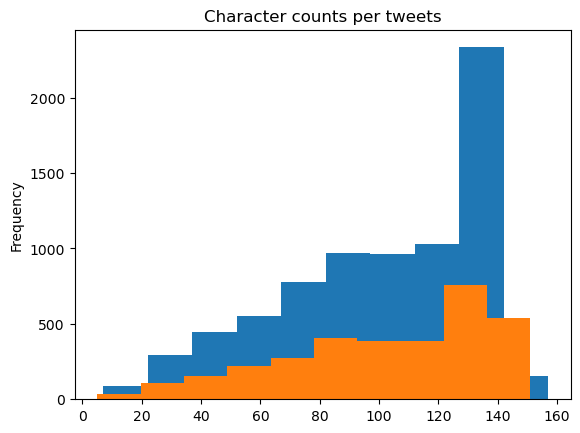

In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

df_train["length"].plot.hist(title="Character counts per tweets")
df_test["length"].plot.hist()

<Axes: title={'center': 'Word counts per tweets'}, ylabel='Frequency'>

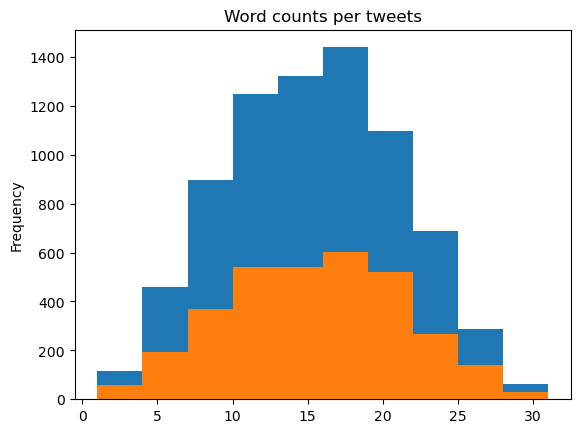

In [8]:
df_train["word_counts"] = df_train["text"].apply(lambda x : len(x.split()))
df_test["word_counts"] = df_test["text"].apply(lambda x : len(x.split()))

df_train["word_counts"].plot.hist(title="Word counts per tweets")
df_test["word_counts"].plot.hist()

In [7]:
disaster_proportion = df_train.target.sum() / df_train.shape[0]

# 2. Gebruik een f-string om de zin te printen
# De notatie {variabele:.0%} zorgt voor de juiste formattering
print(f"Approximately {disaster_proportion:.0%} of the tweets in the training set are classified as disasters.")


Approximately 43% of the tweets in the training set are classified as disasters.


# Preprocess the data

In [11]:
X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test["text"]

In [12]:
X_train

4996    Courageous and honest analysis of need to use ...
3263    @ZachZaidman @670TheScore wld b a shame if tha...
4907    Tell @BarackObama to rescind medals of 'honor'...
2855    Worried about how the CA drought might affect ...
4716    @YoungHeroesID Lava Blast &amp; Power Red #Pan...
                              ...                        
5226    @Eganator2000 There aren't many Obliteration s...
5390    just had a panic attack bc I don't have enough...
860     Omron HEM-712C Automatic Blood Pressure Monito...
7603    Officials say a quarantine is in place at an A...
7270    I moved to England five years ago today. What ...
Name: text, Length: 6090, dtype: object

In [13]:
X_test

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

## Dealing with tweets

Twitter was a social media platform that focussed on short messages. We can see this in the above visualisations where there were on average 18 words in a message. This short-form introduced colloquial terms, and a more informal way of communication. More spelling mistakes, and different tone from for example wikipedia or other places on the internet. Furthermore, these tweets have url's which will not help us with identifying if the tweet is about disatsters or not.
Therefore, to address these particularities, the tweets are cleaned by lowercasing them, and removing the url's. Furthermore, we will use the tweet tokenizer from nltk to treat these tweets better (Loper & Bird, 2002).

When we have finished preprocessing these tweets, we will run a basic Naive-bayes model to get an understanding of what level is a baseline, and continue to investigate improvements.

In [14]:
def preprocess_tweet(text):
    """
    Clean up a tweet by lowercasing it, and removing the urls.
    """
    text = re.sub(r'https?://\S+', '', text)
    return text.lower()


def extract_features(document_tokens):
    """
    Converts a list of words to a vector
    """
    features = {}
    for word in word_features:
        features[f'contains({word})'] = (word in document_tokens)
    return features

if INTERACTIVE_SESSION:
    tknzr = TweetTokenizer()
    
    all_words_in_train = [
        word for tweet in X_train
        for word in tknzr.tokenize(preprocess_tweet(tweet))
    ]
    word_features = nltk.FreqDist(all_words_in_train).keys()
    
    train_set = [
        (extract_features(tknzr.tokenize(preprocess_tweet(tweet))), label)
        for tweet, label in zip(X_train, y_train)
    ]
    
    validation_set = [
        (extract_features(tknzr.tokenize(preprocess_tweet(tweet))), label)
        for tweet, label in zip(X_val, y_val)
    ]

## Naive bayes model for understanding

To be able to understand our data better, and to make sure there are no issues,Establishing a baseline with a basic model is a crucial first step, that will show us any issues, and highlight where we are falling short

In [15]:
if INTERACTIVE_SESSION:
    classifier = nltk.NaiveBayesClassifier.train(train_set)
    accuracy = nltk.classify.accuracy(classifier, validation_set)
    
    print(f"Classifier accuracy: {accuracy:.2%}")
    
    informative_features = classifier.most_informative_features(20)

Classifier accuracy: 81.02%


## Visualising words

Now we have a claissifier which 'understands' which words are more related to a disaster than others, let's visualise them. We will use likelyhood score. You can read this as 'whcih percent of documents containing this word were related to a disaster?'

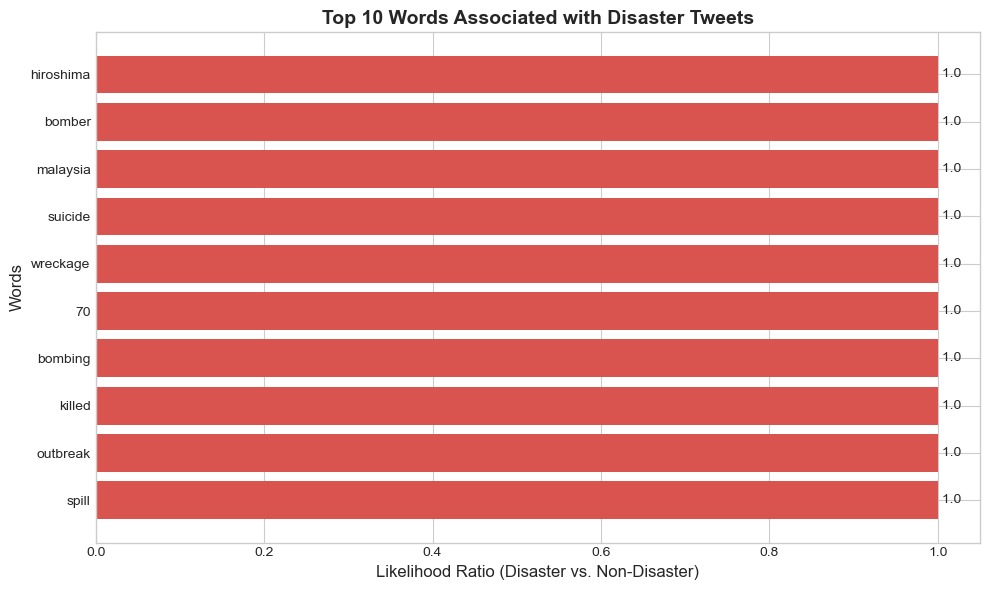

In [16]:
if INTERACTIVE_SESSION and informative_features:
    # Filter for words indicating 'disaster'
    disaster_words = []
    for feature, ratio in informative_features:
        # A feature is a tuple like ('contains(word)', True)
        # NaiveBayesClassifier.most_informative_features() often returns just the feature name
        if isinstance(feature, str) and classifier.classify({feature: True}) == 1:
            # Clean up the feature name to get the word
            word = feature.replace("contains(", "").replace(")", "")
            disaster_words.append((word, ratio))
    
    top_disaster_words = disaster_words[:10]
    
    words = [word for word, ratio in top_disaster_words]
    ratios = [ratio for word, ratio in top_disaster_words]
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.barh(words, ratios, color='#d9534f')
    ax.invert_yaxis()
    
    # Add labels and title
    ax.set_xlabel('Likelihood Ratio (Disaster vs. Non-Disaster)', fontsize=12)
    ax.set_ylabel('Words', fontsize=12)
    ax.set_title(f'Top 10 Words Associated with Disaster Tweets', fontsize=14, fontweight='bold')
    
    # Add the ratio value at the end of each bar
    for index, value in enumerate(ratios):
        ax.text(value, index, f' {value:.1f}', va='center')
    
    plt.tight_layout()

## Tokenisation and embedding

We have successfully built a baseline classification model, but there are several fundamental limitations inherent in its bag-of-words approach. These issues prevent the model from capturing the full complexity of language:

1. **Loss of sequential context**: By treating text as an unordered collection of words, the model loses crucial information contained in word order. The position of a negation like 'no' or 'not' can completely invert a sentence's meaning, a nuance that is entirely lost.
2. **Lack of semantic understanding**: The model possesses no external knowledge. It learns an association between "Hiroshima" and "disaster" purely from statistical co-occurrence in the training data, without understanding the word’s real-world meaning. It also cannot recognize semantic relationships between synonyms (e.g., 'crash' and 'collision').
3. **Vocabulary and morphological brittleness**: The model is unable to handle words not seen during training (Out-of-Vocabulary words). Furthermore, it fails to recognize that words like "crash" and "crashed" are morphologically related and refer to the same concept, treating them as entirely separate features.

To overcome these limitations, we will transition to a more sophisticated architecture combining a Recurrent Neural Network (RNN) with pre-trained word embeddings. To address word order and context, we will use a Long Short-Term Memory (LSTM) network or a Gated recurrent unit, which is specifically designed to process sequential data. We will build this with Tensorflow (Chollet, n.d.; Abadi et al., 2015).

To solve the issues of semantic meaning, vocabulary, and morphology, we will apply FastText embeddings (Bojanowski et al., 2017). While embeddings like Word2Vec and GloVe encode rich semantic knowledge from vast text corpora, FastText offers a critical advantage: it operates on subword information (character n-grams). This allows it to generate meaningful representations for out-of-vocabulary words, handle misspellings, and understand morphological variations, making it a good choice for analyzing dynamic and informal text like tweets. Because of these subwords, we will no longer clean out the documents with URLS or capitals.

In [ ]:
def load_fasttext_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding = 'utf-8', newline = '\n', errors = 'ignore') as f:
        next(f)
        for line in f:
            tokens = line.rstrip().split(' ')
            word = tokens[0]
            vec = np.array(tokens[1:], dtype = 'float32')
            embeddings_index[word] = vec
        print(f"Loaded {len(embeddings_index)} word vectors.")
        return embeddings_index

embedding_index = load_fasttext_embeddings("/kaggle/input/fasttext-wikinews/wiki-news-300d-1M.vec")

# 1. Initialize and fit the tokenizer ON THE TRAINING DATA ONLY
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # +1 for the padding token
print(f"Found {len(word_index)} unique tokens.")

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Shape of padded training data: {X_train_padded.shape}")

In [ ]:

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    # Look up the word's vector in your loaded FastText index
    embedding_vector = embedding_index.get(word)
    
    if embedding_vector is not None:
        # Words not found in the embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

# Model training architecture

To be able to try later different kind of models, let's freeze the common architecture of embeddings and final activation, so we can just track the differences as easy as possible.
For this reason I took a functional approach to build the model and also to train the model. Finally we have a wrapper that will retrieve the different configurations we are interested in, and combine them in an experiment run, and track the histories.

Area under the curve (AUC) was tracked as the primary metric, while the competition works with F1 score. This was a work around where the competition environment for submission did not come with a stable F1-score library, and different attempts to work around this did not result in a stable solution. ROC works in a similar way, where we get no points for a mis-qualified document, so it's a reasonable approach to optimise this score.

In [ ]:
def build_model(recurrent_layer, vocab_size, embedding_dim, max_sequence_length, embedding_matrix, learning_rate=0.001):
    """
    Builds and compiles a text classification model with a specified recurrent layer.

    Args:
        recurrent_layer (tf.keras.layers.Layer): The recurrent layer to use (e.g., LSTM, GRU).
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int): The dimension of the word embeddings.
        max_sequence_length (int): The input length for the sequences.
        embedding_matrix (np.ndarray): The pre-trained embedding matrix.
        learning_rate (float): The learning rate for the optimizer.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    model = Sequential()
    
    # 1. Static Embedding Layer
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_sequence_length,
        trainable=False
    ))
    
    # 2. Dynamic Recurrent Layer (passed as an argument)
    model.add(recurrent_layer)
    
    # 3. Final Classification Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # 4. Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    
    return model

In [ ]:
def train_model(model, model_name, X_train, y_train, X_val, y_val, epochs=100, batch_size=128):
    """
    Trains a Keras model with a standard set of callbacks.

    Args:
        model (tf.keras.Model): The compiled Keras model to train.
        model_name (str): A unique name for the model, used for saving the checkpoint file.
        X_train, y_train: Training data and labels.
        X_val, y_val: Validation data and labels.
        epochs (int): The number of epochs to train for.
        batch_size (int): The size of the training batches.

    Returns:
        tf.keras.callbacks.History: The training history object.
    """
    print(f"--- Prepare data pipeline for: {model_name} ---")

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_padded, y_val))

    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # --- Define Callbacks ---
    
    
    callbacks = [
        EarlyStopping(monitor='val_auc', mode='max', patience=10, verbose=1, restore_best_weights=True),
        ModelCheckpoint(filepath=f'{model_name}_best.keras', save_best_only=True, monitor='val_auc', mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
    ]
    print(f"--- Starting training for model: {model_name} ---")
    # --- Run Training ---
    history = model.fit(
        train_dataset,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    )

    print(f"\n--- Training complete for model: {model_name} ---")
    return history

In [ ]:
def run_experiments(experiments):
    all_histories = {}
    
    for config in experiments:
        model_name = config['model_name']
        
        print("="*50)
        print(f"🚀 STARTING EXPERIMENT: {model_name}")
        print("="*50)
    
        # Build the model using the configuration for this run
        model = build_model(
            recurrent_layer=config['layer'],
            vocab_size=vocab_size,
            embedding_dim=EMBEDDING_DIM,
            max_sequence_length=MAX_SEQUENCE_LENGTH,
            embedding_matrix=embedding_matrix
        )
        
        # Train the model and save the history
        history = train_model(
            model=model,
            model_name=model_name,
            X_train=X_train_padded,
            y_train=y_train,
            X_val=X_val_padded,
            y_val=y_val,
        )
        
        all_histories[model_name] = history
        
        print(f"✅ FINISHED EXPERIMENT: {model_name}")
        time.sleep(2) # Small pause between runs
    return all_histories

def plot_auc_curves(histories):
    for model_name in histories.keys():
        df = pd.DataFrame(histories[model_name].history)
        
        # Set the style of the visualization
        sns.set_style("whitegrid")
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot training and validation AUC (or your primary metric)
        sns.lineplot(data=df, x=df.index, y='auc',  label='Training AUC')
        sns.lineplot(data=df, x=df.index, y='val_auc',  label='Validation AUC')
        ax.set_title(f"""AUC Over Epochs ({model_name})""")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('AUC')
        ax.legend()
        
        plt.tight_layout()
        
        file_name = f"{model_name}_auc_curves.png"
        plt.savefig(file_name)
        
        plt.show()


## Model training: LSTM vs GRU

We discussed before we will use a lstm and a gru to capture the location of the word in a sentence. For this we use the previously discussed model training architecture.

In [ ]:
experiments = [
    {
        'model_name': 'lstm_64_do_02',
        'layer': LSTM(units=64, dropout=0.2),
    },
    {
        'model_name': 'gru_64_do_02',
        'layer': GRU(units=64, dropout=0.2),
    },
]

if INTERACTIVE_SESSION:
    all_histories = run_experiments(experiments)
    plot_auc_curves(all_histories)

| GRU | LSTM |
| :---: | :---: |
| 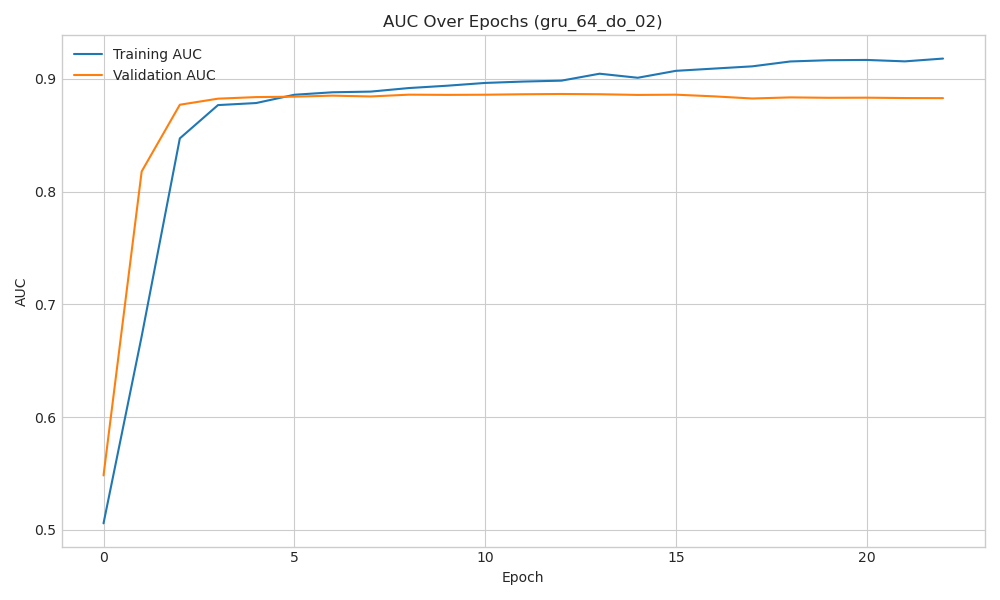| !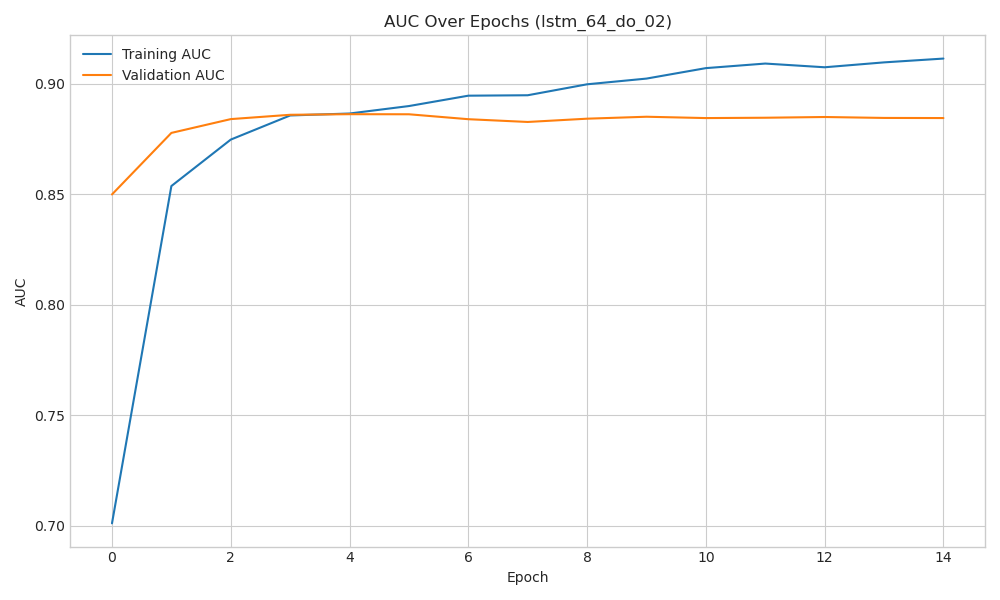|
| Best score: 0.836507 | Best score: 0.840446 |

We have run two models, where the LSTM performed marginally better.  We can see the models scored quickly very similar, but the LSTM started sooner to overfit. The gru was a lot more stable

## Hyper parameter tuning
The GRU architecture was selected for further hyperparameter tuning due to its faster training time and to explore its capabilities relative to the more familiar LSTM.
However, we will try different optimasations:

| Name | Reason |
|---|---|
| `gru_64_units_do_0.2` | A medium-sized GRU with moderate dropout. Our starting point. |
| `gru_128_units_do_0.2` | A larger GRU to see if more model capacity helps. |
| `gru_64_units_do_0.4` | Check if the model is overfitting and needs stronger regularization. |
| `gru_64_units_l2_reg` | An alternative to dropout for controlling overfitting. |
| `gru_64_units_relu_activation` | See if a different activation function changes performance. |
| `lstm_64_units_do_0.2` | A similarly configured LSTM to see which architecture works better. |
| `gru_64_units_do_0.2_lr_1e-4` | Check if a smaller learning rate allows for more stable training. |



In [ ]:


experiments = [

    {
        'model_name': 'gru_64_units_do_0.2',
        'layer': GRU(units=64, dropout=0.2, recurrent_dropout=0.2),
        'learning_rate': 1e-3
    },
    {
        'model_name': 'gru_128_units_do_0.2',
        'layer': GRU(units=128, dropout=0.2, recurrent_dropout=0.2),
        'learning_rate': 1e-3
    },
    {
        'model_name': 'gru_64_units_do_0.4',
        'layer': GRU(units=64, dropout=0.4, recurrent_dropout=0.4),
        'learning_rate': 1e-3
    },
    {
        'model_name': 'gru_64_units_l2_reg',
        'layer': GRU(units=64, kernel_regularizer=l2(1e-4)),
        'learning_rate': 1e-3
    },
    {
        'model_name': 'gru_64_units_relu_activation',
        'layer': GRU(units=64, activation='relu', dropout=0.2, recurrent_dropout=0.2),
        'learning_rate': 1e-3
    },
    {
        'model_name': 'lstm_64_units_do_0.2',
        'layer': LSTM(units=64, dropout=0.2, recurrent_dropout=0.2),
        'learning_rate': 1e-3
    },
    {
        'model_name': 'gru_64_units_do_0.2_lr_1e-4',
        'layer': GRU(units=64, dropout=0.2, recurrent_dropout=0.2),
        'learning_rate': 1e-4
    }
]

if INTERACTIVE_SESSION:
    all_experiments = run_experiments(experiments)

## Results on validation

| Experiment | Max Validation AUC |
| :--- | :--- |
| `gru_64_units_do_0.4` | 0.890 |
| `gru_64_units_do_0.2` | 0.888 |
| `gru_64_units_do_0.2_lr_1e-4`| 0.888 |
| `lstm_64_units_do_0.2` | 0.887 |
| `gru_128_units_do_0.2` | 0.886 |
| `gru_64_units_l2_reg` | 0.885 |
| `gru_64_units_relu_activation` | 0.885 |

It turns out the GRU is already so powerful, the best and worst experiment are only separated by 0.005. Comparing the current GRU baseline with the previous run, the recurrent dropout added the most to the score. Only improvement we could find is to increase the dropout even more, suggesting the current architecture is already too powerful. Also notice a similar GRU as LSTM performed marginally better, confirming the choice to ignore the LSTM

# Submission
We have found the `gru_64_units_do_0.4` to be best performing, and saved the model during run. We will use this model to submit a score.

In [ ]:


# Define the path to your saved model file
model_path = 'gru_64_units_do_0.4_best.keras'

# Load the model into a new variable
loaded_model = load_model(model_path)
loaded_model.summary()

predictions_prob = loaded_model.predict(X_test_padded)
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
sample_submission["target"] = (predictions_prob > 0.5).astype(int)
sample_submission.to_csv("submission.csv", index=False)

# Results

The project progressed through several modeling stages, each yielding an improvement in performance. The initial baseline was established using a Naive Bayes classifier on a bag-of-words representation, which achieved a validation accuracy of **81.02%**. This provided a non-trivial benchmark to exceed.

Transitioning to a sequential architecture with pre-trained FastText embeddings, an initial comparison was made between a Long Short-Term Memory (LSTM) and a Gated Recurrent Unit (GRU) based model. The LSTM model achieved a marginally higher best validation AUC of **0.840**, compared to the GRU's **0.837**. However, the GRU demonstrated more stable training behavior.

Subsequent hyperparameter tuning focused on the GRU architecture due to its stability and efficiency. A series of experiments were conducted, varying parameters such as the number of units, dropout rates, regularization methods, and learning rates. This process identified that adding recurrent dropout was a significant improvement over the initial models. The best-performing model was `gru_64_units_do_0.4`, which achieved a maximum validation AUC of **0.890**.

This optimized model was used for the final submission. The key results are summarized below:

| Model | Validation Metric | Validation Score | Kaggle Public Score (F1) |
| :--- | :--- | :--- | :--- |
| Naive Bayes | Accuracy | 81.02% | Not Submitted |
| LSTM (Initial) | AUC | 0.840 | Not Submitted |
| GRU (Best Tuned) | AUC | 0.890 | **0.812**|

The final public score of **0.812** on the Kaggle leaderboard placed the model competitively, validating the effectiveness of the chosen architecture and tuning process.

# Discussion

The experimental results provide several key insights into the task of classifying disaster tweets. This discussion interprets these results, outlines the main learnings, and proposes directions for future work.

## Interpretation of Results

The most significant performance gain was observed when moving from a bag-of-words model (Naive Bayes) to a recurrent neural network (GRU/LSTM) with pre-trained embeddings. This underscores the limitations of context-agnostic models for this task. By processing text as a sequence and leveraging rich semantic information from FastText embeddings, the RNNs were able to capture nuances in meaning essential for accurate classification.

The comparison between LSTM and GRU revealed that, for this specific dataset and task, the simpler GRU architecture was equally, if not more, effective. While the initial LSTM had a slightly higher validation AUC, the final tuned GRU outperformed a similarly configured LSTM (0.888 vs 0.887)  and exhibited more stable training characteristics. This suggests that the GRU's more efficient architecture was sufficient to capture the necessary temporal dependencies without the additional complexity of the LSTM.

A notable finding is the discrepancy between the high validation AUC (0.890) and the final Kaggle F1-score (0.812). This can be attributed to several factors. Firstly, the model was optimized for AUC, not the F1-score used by the competition, due to technical constraints in the environment. These two metrics are not perfectly correlated. Secondly, the difference suggests that the public test set may have a slightly different data distribution compared to the validation set derived from the training data, leading to a drop in generalization performance.

## Learnings and Takeaways

Several strategies proved effective in improving model performance:
* **Pre-trained Embeddings:** Using FastText was critical. Its ability to handle out-of-vocabulary words and morphological variations by operating on subword information is particularly well-suited for informal text like tweets, which may contain misspellings and neologisms.
* **Regularization:** The model was prone to overfitting. The most effective strategy was applying strong dropout, with the best performance achieved using a 40% dropout rate (`gru_64_units_do_0.4`). The addition of *recurrent dropout* between the initial and final experiments was a key factor in boosting the validation score from ~0.84 to 0.89.
* **Systematic Tuning:** Increasing model complexity, such as using 128 GRU units instead of 64, did not improve performance and in fact led to a slightly lower score (0.886 vs 0.888). This demonstrates that a moderately-sized, well-regularized model was optimal, and that simply adding more capacity was not beneficial.

## Future Improvements

While the current model performs well, several avenues exist for future enhancement:
* **Optimize for the Target Metric:** The highest priority would be to implement a reliable F1-score metric within the training loop. Optimizing the model directly for the competition's evaluation criterion should lead to a better final score.
* **Use all information in the dataset:** We have focussed on the text, and ignored location or keyword information in the dataset. We could try if there is information in there that would support or classification.
* **Advanced Architectures:** Experiment with state-of-the-art NLP architectures. A Bidirectional GRU/LSTM could capture context from both past and future words in a sentence. 
* **Ensemble Methods:** The predictions from several of the top-performing models (e.g., the best GRU and LSTM configurations) could be averaged. Ensembling often leads to a more robust model that generalizes better to unseen data.


# References

* Abadi, M., Agarwal, A., Barham, P., et al. (2015). *TensorFlow: Large-Scale Machine Learning on Heterogeneous Systems*. Geraadpleegd op 15 juli 2025, van https://www.tensorflow.org/

* Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). *Enriching Word Vectors with Subword Information*. Transactions of the Association for Computational Linguistics, 5, 135–146. Geraadpleegd op 15 juli 2025, van https://aclanthology.org/Q17-1010/

* Chollet, F., et al. (n.d.). *Keras Documentation*. Geraadpleegd op 15 juli 2025, van https://keras.io/

* Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. *Nature, 585*(7825), 357-362. Geraadpleegd op 16 juli 2025, van https://www.nature.com/articles/s41586-020-2649-2

* Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. *Computing in Science & Engineering, 9*(3), 90-95. Geraadpleegd op 16 juli 2025, van https://ieeexplore.ieee.org/document/4160265

* Loper, E., & Bird, S. (2002). *NLTK: The Natural Language Toolkit*. Proceedings of the ACL-02 Workshop on Effective tools and methodologies for teaching natural language processing and computational linguistics. Geraadpleegd op 15 juli 2025, van https://aclanthology.org/W02-1011/

* McKinney, W. (2010). Data Structures for Statistical Computing in Python. In *Proceedings of the 9th Python in Science Conference* (Vol. 445, pp. 51-56). Geraadpleegd op 16 juli 2025, van https://proceedings.scipy.org/articles/Majora-92bf1922-00a

* Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research, 12*, 2825-2830. Geraadpleegd op 16 juli 2025, van http://www.jmlr.org/papers/v12/pedregosa11a.html